In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import json
import torch.nn as nn
from torchvision.models.resnet import resnet50
import torchvision.transforms as transforms
import tqdm

In [2]:
img = Image.open('./test.JPEG')
# img = Image.open('./horse.jpg')
img = img.convert('RGB')

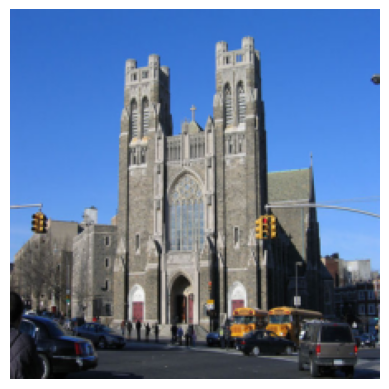

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
img = transform(img)
img_hwc = img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
img = img.unsqueeze(dim=0)

In [4]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
net = resnet50(num_classes=1000, pretrained=True)
model = nn.Sequential(Normalize(mean=imagenet_mean, std=imagenet_std), net)
model.eval()

f:\project\Anaconda3\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\project\Anaconda3\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Normalize()
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [8]:
model.eval()
prob = model(img)
label = torch.argmax(prob.squeeze())
target_class = json.load(open("imagenet_class_index.json"))[str(label.item())]
print("Natural Image:", target_class[1])

Natural Image: church


# Q1: PGD attack
According to the PPT or the original paper, implement the Projected Gradient Desent (PGD) attack.
https://arxiv.org/abs/1706.06083

In [10]:
def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)

def attack_pgd(model, X, y, epsilon=8/255, alpha=2/255, attack_iters=10, restarts=1, lower_limit=torch.tensor([0]), upper_limit=torch.tensor([1])):
    """
    model: Model to attack.
    X: Input image
    y: Class of input image
    epsilon: Budget of PGD attack
    alpha: Step size for PGD attack
    attack_iters: Iterations for PGD attack
    restarts: Restarts for PGD attack
    lower limits: Lower limits for Input Images
    upper limits: Upper limits for Input Images
    """
    ###################################
    # write the code here
    max_loss = -float('inf')
    best_delta = torch.zeros_like(X)
    
    for _ in range(restarts):
        # random initialize
        delta = torch.rand_like(X) * 2 * epsilon - epsilon
        x_adv = (X + delta).clone().requires_grad_(True)
        # clone x_adv
        for _ in range(attack_iters):
            loss = F.cross_entropy(model(x_adv), y)
            model.zero_grad()
            loss.backward()
            with torch.no_grad():
                grad = x_adv.grad
                x_adv = x_adv + alpha * torch.sign(grad)
                x_adv = torch.clamp(x_adv, X - epsilon, X + epsilon)
                x_adv = torch.clamp(x_adv, lower_limit, upper_limit)
                x_adv = x_adv.clone().requires_grad_(True)
        
        with torch.no_grad():
            # for each restart iteration, record delta lead to the max loss 
            current_loss = F.cross_entropy(model(x_adv), y)
            if current_loss > max_loss:
                max_loss = current_loss
                best_delta = x_adv - X
    ###################################
    # return max_delta
    return best_delta.detach()

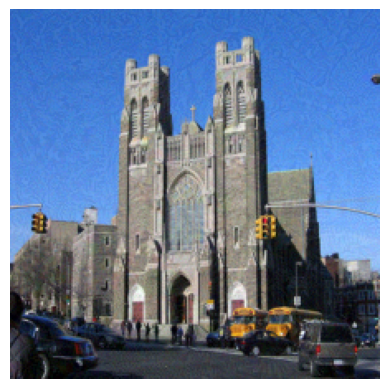

Original correct class: church, label: 497
Adversarial Image:cab, label: 468
Success? True


In [11]:
delta = attack_pgd(model,img,label.unsqueeze(dim=0))
adv_img = img+delta
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
ori_class=json.load(open("imagenet_class_index.json"))[str(label.item())]
attack_label = torch.argmax(prob.squeeze())
attack_class = json.load(open("imagenet_class_index.json"))[str(attack_label.item())]
print(f"Original correct class: {ori_class[1]}, label: {label}")
print(f"Adversarial Image:{attack_class[1]}, label: {attack_label}")
print(f"Success? {ori_class!=attack_class}")


# Q2: C&W attack
According to the PPT shown in the class, implement the Carlini  Wagner (C&W) attack.
https://arxiv.org/pdf/1608.04644.pdf?source=post_page

In [8]:
'''
church : 497
motor_scooter 670
cab 468
'''
def attack_cw(model, X, y, targeted=False,target_index=0, cw_kappa=0, cw_iters=10000, cw_c=1e-4, binary_search_steps = 9 , cw_lr= 0.01):
    """
    model: Model to attack
    X: Input image
    y: Class of input image
    targeted: Whether to apply targeted attack
    cw_kappa: kappa for C&W attack
    cw_iters: iteration for the C&W attack
    cw_c: constants for C&W attack
    binary_search_steps: steps for binary search
    cw_lr: learning rate for optimizer
    """
    def arctanh(imgs):
        scaling = torch.clamp(imgs, max=1, min=-1)
        x = 0.999999 * scaling
        x = 2*x-1
        return 0.5*torch.log((1+x)/(1-x))

    def scaler(x_atanh):
        return ((torch.tanh(x_atanh))+1) * 0.5

    def _f(adv_imgs, labels):
        ###################################
        # write the code here
        logits = model(adv_imgs)
        real_logit = logits.gather(1, labels.view(-1, 1)).squeeze()
        batch_size = logits.shape[0]
        arange = torch.arange(batch_size)

        if not targeted:
            other_logit = logits.clone()
            other_logit[arange, labels] = -float('inf')
            second_max = other_logit.max(dim=1)[0]
            # without target: clip(real_class_prob - second_max_prob, -kappa)
            f_value=torch.clamp(real_logit-second_max, min=-cw_kappa)
        else: # just support batch_size = 1
            target=torch.zeros_like(labels)
            target[0]=target_index# for example
            other_logit = logits.clone()
            target_logit=logits.gather(1, target.view(-1, 1)).squeeze()
            other_logit[:, target_index] = -float('inf')
            max_other = other_logit.max(dim=1)[0]
            # without target: clip(strongest_enermy - target_prob, -kappa)
            f_value = torch.clamp(max_other  - target_logit, min=-cw_kappa)
        ###################################
        # return loss
        return f_value
    
    model.eval()
    X = X.detach().clone()
    x_arctanh = arctanh(X)
    
    for _ in tqdm.tqdm(range(binary_search_steps)):
        '''
        If we use binary_search_steps parameter:
        use c = (c_low + c_high) / 2 to change the cw_c. check if the last attack success
        If attack successfully: decrease c, or increase c 
        '''   
        delta = torch.zeros_like(X, requires_grad=True)
        optimizer = torch.optim.Adam([delta], lr=cw_lr)
        prev_loss = 1e6
        for step in range(cw_iters):
            optimizer.zero_grad()
            adv_examples = scaler(x_arctanh + delta)
            ###################################
            # write the code here
            loss=torch.norm(delta, p=float('inf'))+cw_c*_f(adv_imgs=adv_examples,labels=y)
            loss.backward()
            optimizer.step()
            
            ###################################
            if step % (cw_iters // 10) == 0:
                if loss > prev_loss:
                    break
                prev_loss = loss
        with torch.no_grad(): 
            adv_imgs = scaler(x_arctanh + delta)
            outputs = model(adv_imgs) 
            pred = outputs.argmax(dim=1)

        if not targeted:
            if pred==y: # not success : increase c
                cw_c*=2
            else:# success! break
                break
        else:# targeted attack
            if pred[0]!=target_index: # not success : increase c
                cw_c*=2
            else:# success! break
                break
    return adv_imgs.detach()

  0%|          | 0/9 [00:00<?, ?it/s]

##Attack without target##


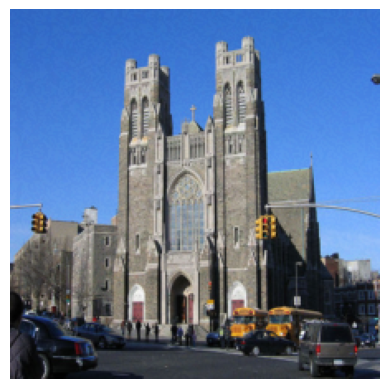

Original correct class: church, label: 497
Adversarial Image:church, label: 442
Success? False


 67%|██████▋   | 6/9 [00:02<00:01,  2.92it/s]

Attack with target goldfish


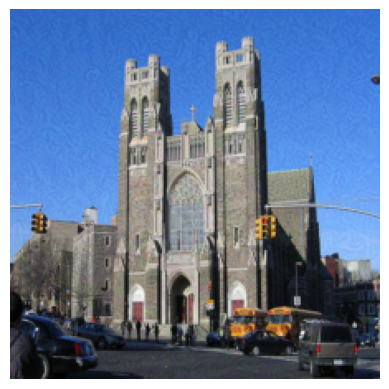

Original correct class: church, label: 497
Target Image:goldfish, label: 1
Adversarial Image:goldfish, label: 1
Success? True


In [9]:
# without target
adv_img = attack_cw(model,img,label.unsqueeze(dim=0),cw_iters=10)
print("##Attack without target##")
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
ori_class=json.load(open("imagenet_class_index.json"))[str(label.item())]
attack_label = torch.argmax(prob.squeeze())
untarget_adv_class = json.load(open("imagenet_class_index.json"))[str(attack_label.item())]
print(f"Original correct class: {ori_class[1]}, label: {label}")
print(f"Adversarial Image:{target_class[1]}, label: {attack_label}")
print(f"Success? {ori_class!=target_class}")

# with target
'''set target'''
target_label=1
target_class = json.load(open("imagenet_class_index.json"))[str(target_label)]
adv_img = attack_cw(model,img,label.unsqueeze(dim=0),targeted=True,target_index=target_label,cw_iters=10)
print(f"Attack with target {target_class[1]}")
adv_img = adv_img.squeeze()
img_hwc = adv_img.permute(1, 2, 0)
plt.imshow(img_hwc)
plt.axis("off")
plt.show()
prob = model(adv_img)
ori_class=json.load(open("imagenet_class_index.json"))[str(label.item())]
adv_label = torch.argmax(prob.squeeze())
adv_class = json.load(open("imagenet_class_index.json"))[str(adv_label.item())]
print(f"Original correct class: {ori_class[1]}, label: {label}")
print(f"Target Image:{target_class[1]}, label: {target_label}")
print(f"Adversarial Image:{adv_class[1]}, label: {adv_label}")
print(f"Success? {adv_label==target_label}")